In [ ]:
from IPython.display import clear_output
!pip install anndata seaborn umap-learn openpyxl
clear_output()

In [ ]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'
from IPython.display import display, clear_output

import os
import boto3
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import anndata as ad

# Download the embeddings and metadata

In [ ]:
s3 = boto3.client('s3')
bucket_name = 'rxrx-data'

files_to_download = [
    {'key': 'rxrx19a/RxRx19a/embeddings.csv', 'filename': 'data/rxrx19a_embeddings.csv'},
    {'key': 'rxrx19a/RxRx19a/metadata.csv', 'filename': 'data/rxrx19a_metadata.csv'},
    {'key': 'rxrx19b/embeddings.csv', 'filename': 'data/rxrx19b_embeddings.csv'},
    {'key': 'rxrx19b/metadata.csv', 'filename': 'data/rxrx19b_metadata.csv'}
]

os.makedirs('data', exist_ok=True)

def download_file_from_s3(s3_client, bucket, key, local_filename):
    try:
        print(f"Downloading {key} to {local_filename}...")
        s3_client.download_file(bucket, key, local_filename)
        print(f"Downloaded: {local_filename}")
    except Exception as e:
        print(f"Error downloading {key}: {e}")
        
for file in files_to_download:
    download_file_from_s3(s3, bucket_name, file['key'], file['filename'])


In [183]:
small_drug_targets = pd.read_excel('RXRX Metadata.xlsx', sheet_name=2, index_col=0, header=1)
small_drug_targets.reset_index(inplace=True, drop=True)


def aggregate_compound_info(df):
    aggregated_df = df.groupby('compound').agg({
        'target': lambda x: ';'.join(sorted(set(x))),
        'indication': lambda x: ';'.join(sorted(set(x))),
        'fda_status': lambda x: ';'.join(sorted(set(x)))
    }).reset_index()
    return aggregated_df

# Call the function to get the aggregated DataFrame
small_drug_targets = aggregate_compound_info(small_drug_targets)


# small_drug_targets = small_drug_targets.groupby('compound')['target'].apply(lambda x: ';'.join(x)).reset_index()
small_drug_targets

,compound,target,indication,fda_status
0,ABT-199,BCL2,"Chronic Lymphocytic Leukemia (CLL), Acute Myel...",Approved
1,ABT-263,BCL2;BCL2L1;BCL2L2,Cancer,Phase 2
2,ABT-737,BCL2;BCL2L1;BCL2L2,Cancer,Preclinical
3,AZD1080,GSK3A;GSK3B,Alzheimer's Disease,Preclinical
4,AZD1283,SELP,Thrombosis,Preclinical
...,...,...,...,...
107,Vandetanib,EGFR;KDR;RET,Medullary Thyroid Cancer,Approved
108,Vemurafenib,BRAF,"Melanoma, Erdheim-Chester Disease",Approved
109,Vismodegib,SMO,Basal Cell Carcinoma,Approved
110,brigatinib,ALK;FLT3;IGF1R;ROS1,Non-Small Cell Lung Cancer (NSCLC),Approved


# Looking at the metadata

In [184]:
rxrx19a_metadata = pd.read_csv('data/rxrx19a_metadata.csv', index_col=0)
rxrx19b_metadata = pd.read_csv('data/rxrx19b_metadata.csv', index_col=0)

rxrx19b_metadata = rxrx19b_metadata.merge(small_drug_targets, left_on='treatment', right_on='compound', how='left')
rxrx19b_metadata.set_index('well_id', inplace=True)

rxrx19b_metadata.head(1)
rxrx19b_metadata.head(1)

rxrx19a_metadata.shape
rxrx19b_metadata.shape

,cell_type,experiment,plate,well,site,disease_condition,treatment,treatment_conc,SMILES,compound,target,indication,fda_status
well_id,,,,,,,,,,,,,
HUVEC-1_1_AA02,HUVEC,HUVEC-1,1,AA02,1,storm-severe,Ravoxertinib,1.0,CN1N=CC=C1NC1=NC=CC(=N1)C1=CC(=O)N(C=C1)C(CO)C...,NaN,NaN,NaN,NaN


,cell_type,experiment,plate,well,site,disease_condition,treatment,treatment_conc,SMILES,compound,target,indication,fda_status
well_id,,,,,,,,,,,,,
HUVEC-1_1_AA02,HUVEC,HUVEC-1,1,AA02,1,storm-severe,Ravoxertinib,1.0,CN1N=CC=C1NC1=NC=CC(=N1)C1=CC(=O)N(C=C1)C(CO)C...,NaN,NaN,NaN,NaN


(305520, 10)

(70384, 13)

In [185]:
rxrx19b_metadata.head()
rxrx19b_embeddings.shape
rxrx19b_metadata.shape


,cell_type,experiment,plate,well,site,disease_condition,treatment,treatment_conc,SMILES,compound,target,indication,fda_status
well_id,,,,,,,,,,,,,
HUVEC-1_1_AA02,HUVEC,HUVEC-1,1,AA02,1,storm-severe,Ravoxertinib,1.00,CN1N=CC=C1NC1=NC=CC(=N1)C1=CC(=O)N(C=C1)C(CO)C...,NaN,NaN,NaN,NaN
HUVEC-1_1_AA03,HUVEC,HUVEC-1,1,AA03,1,storm-severe,Diphenylpyraline,0.25,"CN1CCC(CC1)OC(C1=CC=CC=C1)C1=CC=CC=C1 |c:12,14...",NaN,NaN,NaN,NaN
HUVEC-1_1_AA04,HUVEC,HUVEC-1,1,AA04,1,storm-severe,Indirubin,1.00,O=C1NC2=CC=CC=C2\C1=C1\NC2=C(C=CC=C2)C1=O |c:5...,NaN,NaN,NaN,NaN
HUVEC-1_1_AA05,HUVEC,HUVEC-1,1,AA05,1,storm-severe,YO-01027,1.00,C[C@H](NC(=O)CC1=CC(F)=CC(F)=C1)C(=O)N[C@H]1C2...,NaN,NaN,NaN,NaN
HUVEC-1_1_AA07,HUVEC,HUVEC-1,1,AA07,1,storm-severe,taurine,1.00,NCCS(O)(=O)=O,NaN,NaN,NaN,NaN


(70384, 128)

(70384, 13)

# Load embeddings

In [ ]:
rxrx19a_embeddings = pd.read_csv('data/rxrx19a_embeddings.csv', index_col=0)

In [ ]:
rxrx19a_embeddings.head(1)
rxrx19a_embeddings.shape

In [ ]:
rxrx19b_embeddings = pd.read_csv('data/rxrx19b_embeddings.csv', index_col=0)

In [ ]:
rxrx19b_embeddings.head(1)
rxrx19b_embeddings.shape

# Create AnnData objects

Combine the metadata and embeddings into a single object for easier querying.

In [186]:
def create_anndata(embeddings: pd.DataFrame, metadata: pd.DataFrame, file_name=None):
    """
    Combines embeddings and metadata into an AnnData object and saves as an h5ad file.
    
    Parameters:
    embeddings (pd.DataFrame): DataFrame containing the embeddings.
    metadata (pd.DataFrame): DataFrame containing the metadata.
    file_name (str): Name of the file to save the AnnData object (e.g., 'rxrx19a.h5ad').
    
    Returns:
    adata (AnnData): The created AnnData object.
    """
    # create the AnnData object using the embeddings
    adata = ad.AnnData(X=embeddings.values)
    
    # set site_id as the index for both dataframes
    adata.obs = metadata
    adata.var_names = embeddings.columns

    if file_name is not None:
        # save the AnnData object to an h5ad file
        adata.write(file_name)
    
    return adata

# rxrx19a_adata = create_anndata(rxrx19a_embeddings, rxrx19a_metadata)


# rxrx19b_metadata.set_index('well_id', inplace=True)

# ix = rxrx19b_metadata.index.intersection(rxrx19b_embeddings.index)
rxrx19b_adata = create_anndata(rxrx19b_embeddings, rxrx19b_metadata)

# rxrx19a_adata
rxrx19b_adata

AnnData object with n_obs × n_vars = 70384 × 128
    obs: 'cell_type', 'experiment', 'plate', 'well', 'site', 'disease_condition', 'treatment', 'treatment_conc', 'SMILES', 'compound', 'target', 'indication', 'fda_status'

In [277]:
rxrx19b_adata.write_h5ad('rxrx19b.h5ad')
rxrx19a_adata.write_h5ad('rxrx19a.h5ad')

In [150]:
import pandas as pd
import numpy as np
import anndata as ad

def explode_targets(adata, target_column):
    """
    Explodes the specified target column in adata.obs, splitting values by ';',
    and ensures the adata.X matrix aligns with the expanded rows.

    Parameters:
        adata (anndata.AnnData): The input AnnData object.
        target_column (str): The column in adata.obs to split and explode.

    Returns:
        anndata.AnnData: A new AnnData object with exploded targets and aligned X matrix.
    """
    # convert obs to dataframe and split the target column by ';'
    obs_df = adata.obs.copy()
    obs_df[target_column] = obs_df[target_column].str.split(';')

    # explode the target column to create new rows
    exploded_df = obs_df.explode(target_column)

    # repeat the rows in X to align with the exploded rows
    row_repeats = exploded_df.groupby(exploded_df.index).size().values
    exploded_X = np.repeat(adata.X, row_repeats, axis=0)

    # build a new AnnData object with the exploded obs and aligned X matrix
    exploded_adata = ad.AnnData(exploded_X, 
                                obs=exploded_df, 
                                var=adata.var, 
                                obsm=adata.obsm)

    # ensure obs_names are preserved correctly for exploded entries
    exploded_adata.obs_names = exploded_df.index
    exploded_adata.obs_names_make_unique()  # In-place I think
    return exploded_adata

rxrx19b_adata = explode_targets(rxrx19b_adata, 'target')
rxrx19b_adata

/home/ec2-user/anaconda3/envs/pytorch_p310/lib/python3.10/site-packages/anndata/_core/anndata.py:1754: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


AnnData object with n_obs × n_vars = 75688 × 128
    obs: 'cell_type', 'experiment', 'plate', 'well', 'site', 'disease_condition', 'treatment', 'treatment_conc', 'SMILES', 'compound', 'target'

In [152]:
def group_targets_by_category(adata, target_column):
    """
    Adds a new column to adata.obs grouping targets into higher-level categories.
    
    Parameters:
        adata (anndata.AnnData): Input AnnData object.
        target_column (str): Column in obs containing individual targets.

    Returns:
        anndata.AnnData: AnnData with an added 'target_group' column in obs.
    """

    # define target groups (you can refine these as needed)
    target_groups = {
        "ABL": ["ABL1", "BCR", "LYN"],
        "AKT": ["AKT1", "AKT2", "AKT3"],
        "ALK": ["ALK", "NTRK1", "NTRK2", "NTRK3"],
        "AUR": ["AURKB", "AURKC"],
        "BCL": ["BCL2", "BCL2L1", "BCL2L2"],
        "CDK": ["CDK4", "CDK6"],
        "EGFR": ["EGFR", "ERBB2", "ERBB4"],
        "FGFR": ["FGFR1", "FGFR2", "FGFR3", "FGFR4"],
        "FLT": ["FLT1", "FLT3", "FLT4"],
        "JAK": ["JAK1", "JAK2", "JAK3"],
        "MAPK": ["MAP2K1", "MAP2K2", "MAPK1", "MAPK3", "MAPK14"],
        "MTOR": ["MTOR"],
        "PIK3": ["PIK3CA", "PIK3CB", "PIK3CD", "PIK3CG"],
        "PTK": ["PTK2", "PTK2B"],
        "RAF": ["RAF1", "BRAF"],
        "RET": ["RET"],
        "SRC": ["SRC", "YES1", "FYN"],
        "SYK": ["SYK"],
    }

    # map targets to their respective groups
    def map_to_group(target):
        for group, members in target_groups.items():
            if target in members:
                return group
        return "Other"  # fallback for uncategorized targets

    # apply the grouping function to the target column
    adata.obs["target_group"] = adata.obs[target_column].apply(map_to_group)

    return adata

group_targets_by_category(rxrx19b_adata, target_column='target')

AnnData object with n_obs × n_vars = 75688 × 128
    obs: 'cell_type', 'experiment', 'plate', 'well', 'site', 'disease_condition', 'treatment', 'treatment_conc', 'SMILES', 'compound', 'target', 'target_group'

# Dimensionality Reductions

PCA and UMAP. Runs `sklearn.preprocessing.StandardScaler`.

Results are stored in the `adata` object.

Plotting functions will also take in the `adata` object.

In [153]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import umap

def run_pca(adata, n_components=2, scale=True, copy=False):
    if copy:
        adata = adata.copy()
    if scale:
        data = StandardScaler().fit_transform(adata.X)
    pca = PCA(n_components=n_components)
    result = pca.fit_transform(data)
    adata.obsm['X_pca'] = result  # save PCA results in adata.obsm
    adata.uns['pca'] = {'variance_ratio': pca.explained_variance_ratio_}  # store explained variance
    return adata if copy else None


def run_umap(adata, n_components=2, n_neighbors=15, scale=True, copy=False):
    if copy:
        adata = adata.copy()
    data = adata.X
    if scale:
        data = StandardScaler().fit_transform(data)
    umap_model = umap.UMAP(n_components=n_components, n_neighbors=n_neighbors)
    result = umap_model.fit_transform(data)
    
    adata.obsm['X_umap'] = result  # save UMAP results in adata.obsm
    return adata if copy else None

In [165]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

def plot_pca(adata, color_by=None, shape_by=None, ax=None, palette='tab20', legend_cols=3):
    if ax is None:
        fig, ax = plt.subplots(figsize=(8, 6))
    
    # get pca data
    pca_data = adata.obsm['X_pca']
    explained_variance = adata.uns['pca']['variance_ratio']
    
    # prepare dataframe with pca data and metadata
    df = pd.DataFrame(pca_data, columns=[f'PC{i+1}' for i in range(pca_data.shape[1])])
    if color_by is not None:
        df['color_by'] = adata.obs[color_by].values
    if shape_by is not None:
        df['shape_by'] = adata.obs[shape_by].values
    
    # plot pca
    sns.scatterplot(
        data=df,
        x='PC1', y='PC2',
        hue='color_by' if color_by else None,
        style='shape_by' if shape_by else None,
        ax=ax,
        palette=palette
    )
    
    ax.set_title('PCA')
    ax.set_xlabel(f'PC1 ({explained_variance[0] * 100:.2f}% variance)')
    ax.set_ylabel(f'PC2 ({explained_variance[1] * 100:.2f}% variance)')

    # manage legend: control columns and place it outside the plot
    if color_by is not None:
        legend = ax.legend(
            loc='center left', 
            bbox_to_anchor=(1, 0.5), 
            ncol=legend_cols,  # control number of legend columns
            frameon=False
        )

    plt.show()

    
def plot_umap(adata, color_by=None, shape_by=None, ax=None, legend_cols=3):
    if ax is None:
        fig, ax = plt.subplots(figsize=(8, 6))

    # get umap data
    umap_data = adata.obsm['X_umap']

    # prepare dataframe with umap data and metadata
    df = pd.DataFrame(umap_data, columns=[f'UMAP{i+1}' for i in range(umap_data.shape[1])])
    if color_by is not None:
        df['color_by'] = adata.obs[color_by].values
    if shape_by is not None:
        df['shape_by'] = adata.obs[shape_by].values

    # plot umap
    sns.scatterplot(
        data=df,
        x='UMAP1', y='UMAP2',
        hue='color_by' if color_by else None,
        style='shape_by' if shape_by else None,
        ax=ax,
        palette='tab20'
    )

    ax.set_title('UMAP')
    ax.set_xlabel('UMAP1')
    ax.set_ylabel('UMAP2')

    # manage legend: control columns and place it outside the plot
    if color_by is not None:
        legend = ax.legend(
            loc='center left', 
            bbox_to_anchor=(1, 0.5), 
            ncol=legend_cols,  # control number of legend columns
            frameon=False
        )

    plt.show()

## PCA

In [187]:
# run_pca(rxrx19a_adata)
run_pca(rxrx19b_adata)

## UMAP

Takes a little bit to run. RAM goes to ~22gb.

In [ ]:
# run_umap(rxrx19a_adata)

In [188]:
run_umap(rxrx19b_adata, n_neighbors=15)  # Increase n_neighbors to make sure the graph is fully-connected

## Plot

KeyError: 'X_pca'

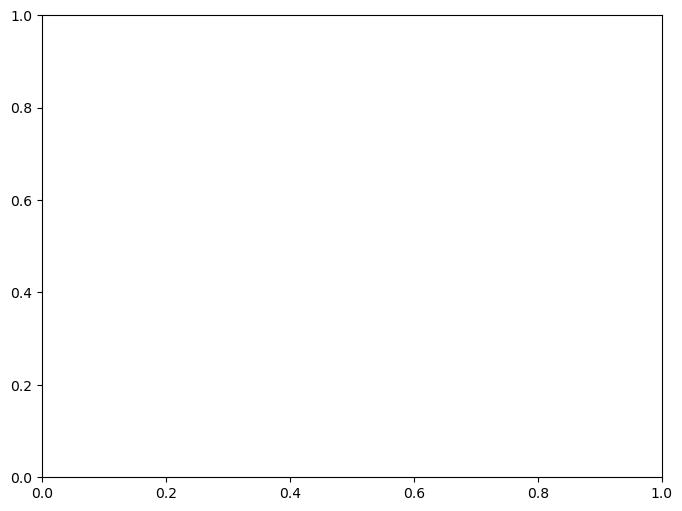

In [119]:
# plot_pca(rxrx19a_adata, color_by='cell_type')

In [190]:
# rxrx19b_adata.obs

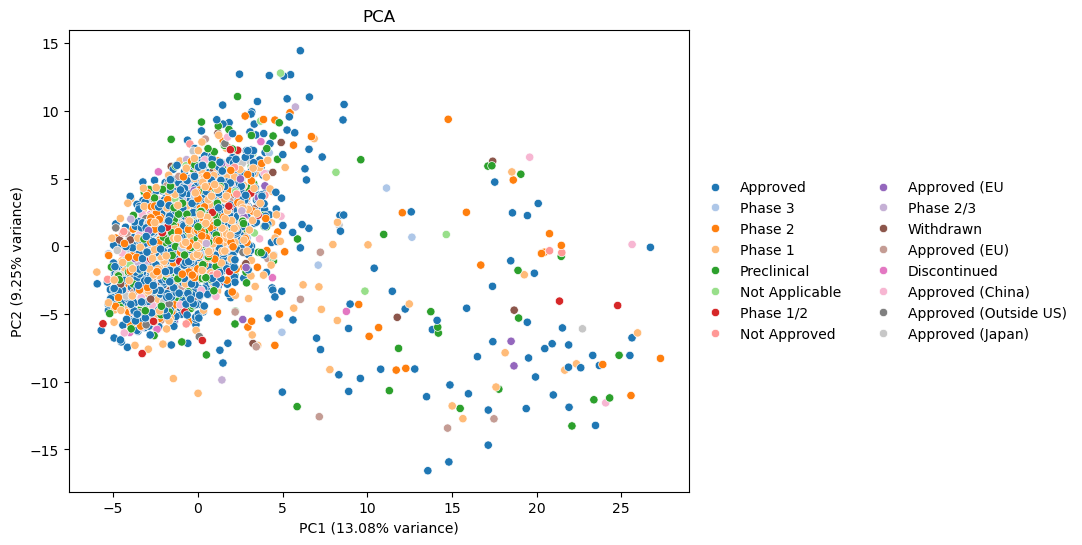

In [196]:
plot_pca(rxrx19b_adata, color_by='fda_status', legend_cols=2)

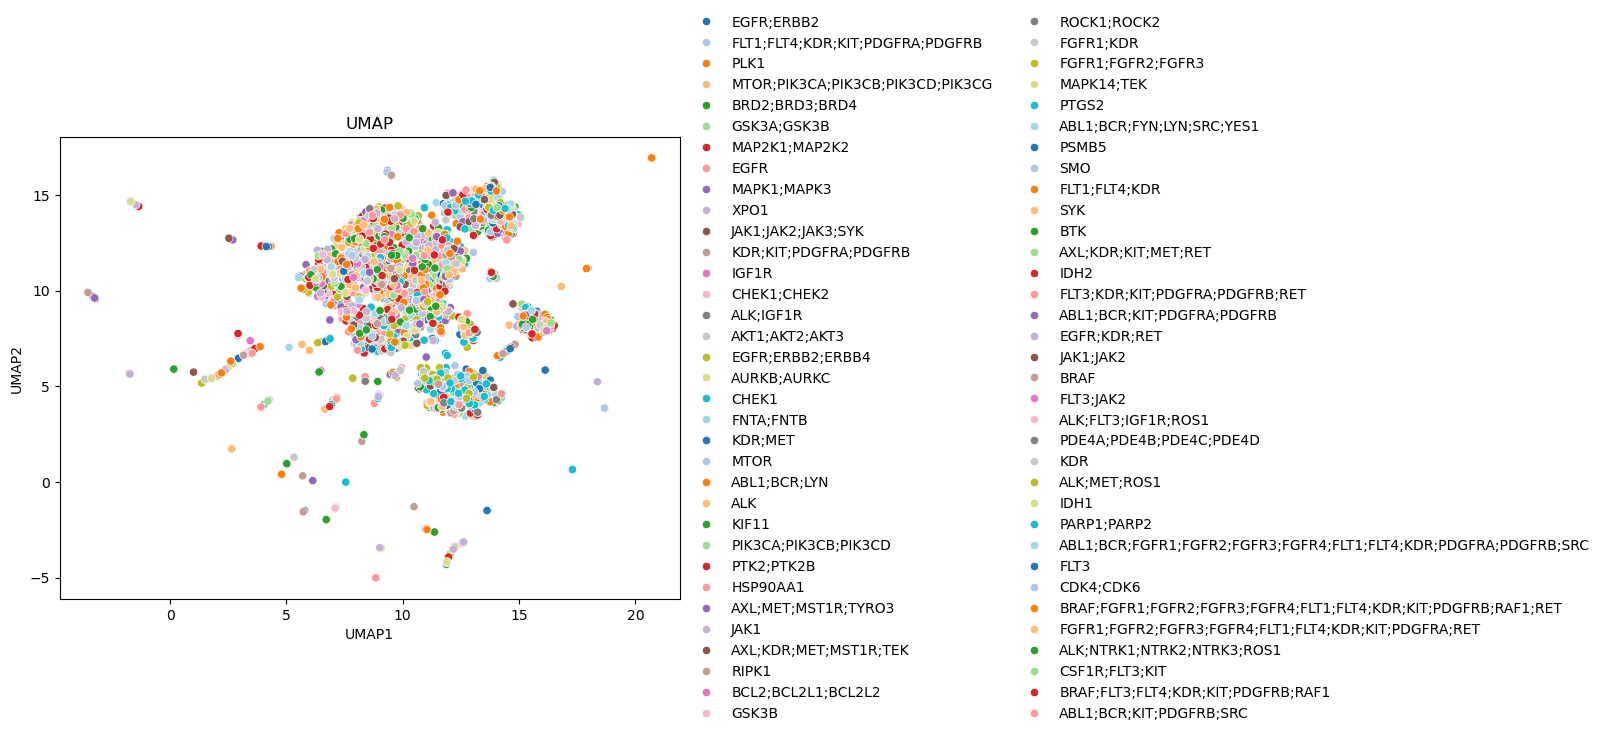

In [197]:
plot_umap(rxrx19b_adata, color_by='target', legend_cols=2)

In [214]:
egfr_inhibitors = [
    'neratinib', 'gefitinib', 'lapatinib', 
    'afatinib', 'icotinib', 'vandetanib', 
    'olmutinib', 'azd9291', 'erlotinib', 
    'osi-420', 'dacomitinib'
]

rxrx19b_adata[rxrx19b_adata.obs['treatment'].str.lower().isin(egfr_inhibitors)]

View of AnnData object with n_obs × n_vars = 372 × 128
    obs: 'cell_type', 'experiment', 'plate', 'well', 'site', 'disease_condition', 'treatment', 'treatment_conc', 'SMILES', 'compound', 'target', 'indication', 'fda_status'
    uns: 'pca'
    obsm: 'X_pca', 'X_umap'

In [235]:
# rxrx19b_adata_filt = rxrx19b_adata[rxrx19b_adata.obs['target_group'] != 'Other', :]
rxrx19b_adata_filt = rxrx19b_adata[
    (rxrx19b_adata.obs['treatment'].str.lower().isin(egfr_inhibitors)),
    :
]

In [236]:
rxrx19b_adata_filt.obs

,cell_type,experiment,plate,well,site,disease_condition,treatment,treatment_conc,SMILES,compound,target,indication,fda_status
well_id,,,,,,,,,,,,,
HUVEC-1_1_AA24,HUVEC,HUVEC-1,1,AA24,1,storm-severe,Lapatinib,1.00,CS(=O)(=O)CCNCC1=CC=C(O1)C1=CC=C2N=CN=C(NC3=CC...,Lapatinib,EGFR;ERBB2,Breast Cancer,Approved
HUVEC-1_1_AC31,HUVEC,HUVEC-1,1,AC31,1,storm-severe,OSI-420,3.00,COCCOC1=CC2=C(C=C1OCCO)C(NC1=CC=CC(=C1)C#C)=NC...,OSI-420,EGFR,Metabolite of Erlotinib,Not Applicable
HUVEC-1_1_AE27,HUVEC,HUVEC-1,1,AE27,1,storm-severe,Afatinib,0.30,CN(C)CC=CC(=O)NC1=C(OC2CCOC2)C=C2N=CN=C(NC3=CC...,Afatinib,EGFR;ERBB2;ERBB4,Non-Small Cell Lung Cancer (NSCLC),Approved
HUVEC-1_1_E23,HUVEC,HUVEC-1,1,E23,1,storm-severe,Lapatinib,0.01,CS(=O)(=O)CCNCC1=CC=C(O1)C1=CC=C2N=CN=C(NC3=CC...,Lapatinib,EGFR;ERBB2,Breast Cancer,Approved
HUVEC-1_1_F28,HUVEC,HUVEC-1,1,F28,1,storm-severe,Lapatinib,0.10,CS(=O)(=O)CCNCC1=CC=C(O1)C1=CC=C2N=CN=C(NC3=CC...,Lapatinib,EGFR;ERBB2,Breast Cancer,Approved
...,...,...,...,...,...,...,...,...,...,...,...,...,...
HUVEC-1_53_C05,HUVEC,HUVEC-1,53,C05,1,storm-severe,Afatinib,0.10,CN(C)CC=CC(=O)NC1=C(OC2CCOC2)C=C2N=CN=C(NC3=CC...,Afatinib,EGFR;ERBB2;ERBB4,Non-Small Cell Lung Cancer (NSCLC),Approved
HUVEC-1_53_C25,HUVEC,HUVEC-1,53,C25,1,storm-severe,OSI-420,3.00,COCCOC1=CC2=C(C=C1OCCO)C(NC1=CC=CC(=C1)C#C)=NC...,OSI-420,EGFR,Metabolite of Erlotinib,Not Applicable
HUVEC-1_53_O09,HUVEC,HUVEC-1,53,O09,1,storm-severe,OSI-420,0.30,COCCOC1=CC2=C(C=C1OCCO)C(NC1=CC=CC(=C1)C#C)=NC...,OSI-420,EGFR,Metabolite of Erlotinib,Not Applicable


In [227]:
(rxrx19b_adata.obs['treatment'].str.lower().isin(egfr_inhibitors)).sum()

372

In [252]:
run_pca(rxrx19b_adata_filt)
run_umap(rxrx19b_adata_filt, n_neighbors=10)

In [ ]:
rxrx19b_adata_filt

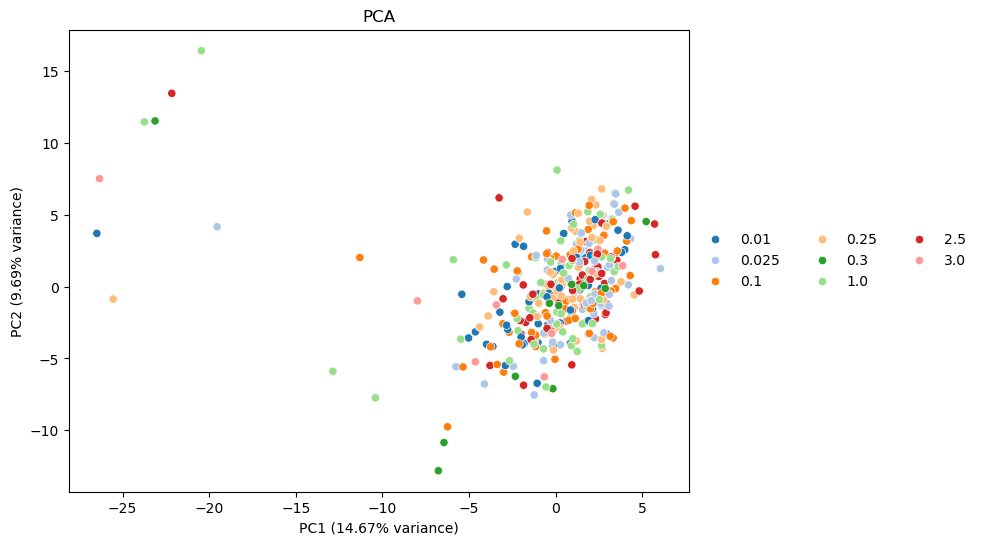

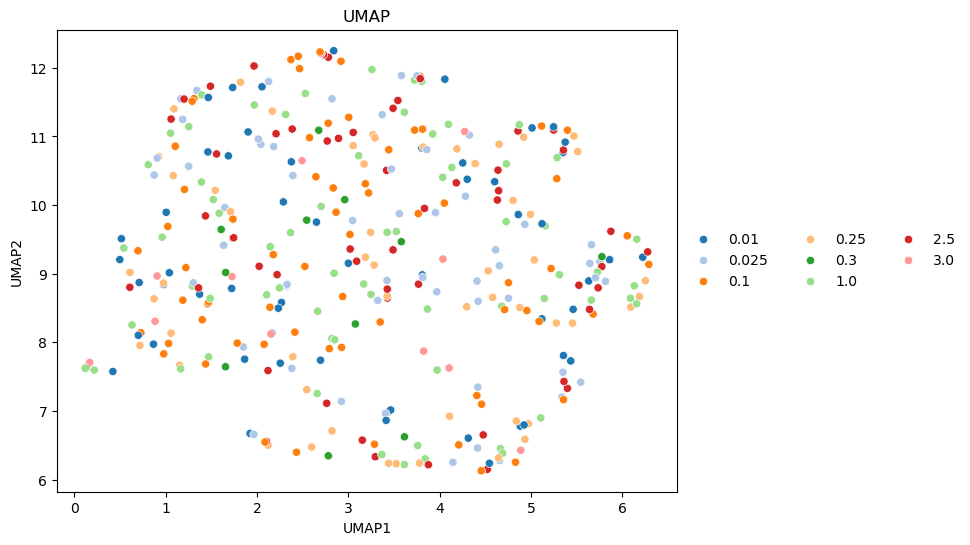

In [253]:
plot_pca(rxrx19b_adata_filt, color_by='treatment_conc')
plot_umap(rxrx19b_adata_filt, color_by='treatment_conc')

In [268]:
rxrx19b_adata_filt.obs

,cell_type,experiment,plate,well,site,disease_condition,treatment,treatment_conc,SMILES,compound,target,indication,fda_status
well_id,,,,,,,,,,,,,
HUVEC-1_1_AA24,HUVEC,HUVEC-1,1,AA24,1,storm-severe,Lapatinib,1.00,CS(=O)(=O)CCNCC1=CC=C(O1)C1=CC=C2N=CN=C(NC3=CC...,Lapatinib,EGFR;ERBB2,Breast Cancer,Approved
HUVEC-1_1_AC31,HUVEC,HUVEC-1,1,AC31,1,storm-severe,OSI-420,3.00,COCCOC1=CC2=C(C=C1OCCO)C(NC1=CC=CC(=C1)C#C)=NC...,OSI-420,EGFR,Metabolite of Erlotinib,Not Applicable
HUVEC-1_1_AE27,HUVEC,HUVEC-1,1,AE27,1,storm-severe,Afatinib,0.30,CN(C)CC=CC(=O)NC1=C(OC2CCOC2)C=C2N=CN=C(NC3=CC...,Afatinib,EGFR;ERBB2;ERBB4,Non-Small Cell Lung Cancer (NSCLC),Approved
HUVEC-1_1_E23,HUVEC,HUVEC-1,1,E23,1,storm-severe,Lapatinib,0.01,CS(=O)(=O)CCNCC1=CC=C(O1)C1=CC=C2N=CN=C(NC3=CC...,Lapatinib,EGFR;ERBB2,Breast Cancer,Approved
HUVEC-1_1_F28,HUVEC,HUVEC-1,1,F28,1,storm-severe,Lapatinib,0.10,CS(=O)(=O)CCNCC1=CC=C(O1)C1=CC=C2N=CN=C(NC3=CC...,Lapatinib,EGFR;ERBB2,Breast Cancer,Approved
...,...,...,...,...,...,...,...,...,...,...,...,...,...
HUVEC-1_53_C05,HUVEC,HUVEC-1,53,C05,1,storm-severe,Afatinib,0.10,CN(C)CC=CC(=O)NC1=C(OC2CCOC2)C=C2N=CN=C(NC3=CC...,Afatinib,EGFR;ERBB2;ERBB4,Non-Small Cell Lung Cancer (NSCLC),Approved
HUVEC-1_53_C25,HUVEC,HUVEC-1,53,C25,1,storm-severe,OSI-420,3.00,COCCOC1=CC2=C(C=C1OCCO)C(NC1=CC=CC(=C1)C#C)=NC...,OSI-420,EGFR,Metabolite of Erlotinib,Not Applicable
HUVEC-1_53_O09,HUVEC,HUVEC-1,53,O09,1,storm-severe,OSI-420,0.30,COCCOC1=CC2=C(C=C1OCCO)C(NC1=CC=CC(=C1)C#C)=NC...,OSI-420,EGFR,Metabolite of Erlotinib,Not Applicable


In [274]:
# define a color map for treatment concentrations
# treatment_conc = rxrx19b_adata_filt.obs['treatment_conc']
# unique_concs = treatment_conc.unique()
# conc_colors = sns.color_palette("coolwarm", len(unique_concs))

# # create a dataframe with concentration colors
# conc_color_map = {conc: color for conc, color in zip(unique_concs, conc_colors)}
# conc_col_colors = treatment_conc.map(conc_color_map)

# # combine both levels of column colors into a DataFrame
# col_colors_df = pd.DataFrame({
#     'treatment': treatments.map(treatment_color_map),
#     'treatment_conc': conc_col_colors
# })

# plot clustermap with both treatment and treatment_conc as column colors
sns.clustermap(rxrx19b_adata.to_df().T.corr(), metric='cosine', cmap='RdBu_r', robust=True)


MemoryError: Unable to allocate 36.9 GiB for an array with shape (70384, 70384) and data type float64

In [273]:
!pip install fastcluster

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.0/194.0 kB 4.9 MB/s eta 0:00:00a 0:00:01


In [ ]:
# plot_umap(rxrx19a_adata, color_by='cell_type')

# Get the HUVEC control samples

In [ ]:
# Filter for treatment and disease_condition being NaN in rxrx19b
control_huvec_adata = (
    rxrx19b_adata[
        rxrx19b_adata.obs['treatment'].isna() \
        & rxrx19b_adata.obs['disease_condition'].isna(), :]
)
print(f'Number of control HUVEC samples: {len(control_huvec_adata.obs_names)}')

In [ ]:
from sklearn.metrics.pairwise import cosine_distances
def pairwise_cosine_distance(adata):
    # Compute the pairwise cosine distances
    cosine_dist_matrix = cosine_distances(adata.X)
    
    # Extract the upper triangle of the distance matrix, excluding the diagonal
    triu_indices = np.triu_indices_from(cosine_dist_matrix, k=1)
    upper_triangle = cosine_dist_matrix[triu_indices]
    return upper_triangle
    sns.histplot(upper_triangle)
    # Compute the average cosine distance
    avg_cosine_dist = np.mean(upper_triangle)
    return avg_cosine_dist

control_cosine_distances = pairwise_cosine_distance(control_huvec_adata)

# Plot the distribution of cosine distances
with sns.plotting_context('talk'):
    fig, ax = plt.subplots(figsize=(7, 7))
    _ = sns.histplot(control_cosine_distances)
    _ = fig.suptitle(f'Pairwise Phenoprint Distances for Untreated HUVEC cells (mean {np.mean(control_cosine_distances):.2g})')
